# Homework 8 - Artificial Neural Networks with PyTorch

## About 

### In this homework, you will get your feet wet with deep learning using the PyTorch deep learning platform. This will involve:
* Preparing data 
* Learning about the components of a deep learning pipeline
* Setting up a model, a loss function, and an optimizer
* Setting up training and testing loops
* Using a visualizer like tensorboard to monitor logged data

*This homework is due __April 15th 2019__. Training neural networks takes some time, particularly on CPUs so start early.* 


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service. 
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW8.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`

Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.9198, 0.9627, 0.8550],
        [0.1658, 0.1416, 0.4109],
        [0.5510, 0.4664, 0.4003],
        [0.8661, 0.8288, 0.3942],
        [0.8051, 0.7677, 0.5237]])

The output should look something like

```python
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

### Let's get started with the assignment.

## Instructions
### Part 1 -  Datasets and Dataloaders (10 points)

In this section we will download the MNIST dataset using PyTorch's own API.

Helpful Resources:
* https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
* https://pytorch.org/docs/stable/torchvision/transforms.html
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We are particularly concerned with `torchvision.datasets` and `torchvision.transforms`. Check out the API for these modules in the links provided above.

**Create a directory named `hw8_data` with the following command**.

In [2]:
!mkdir hw8_data

mkdir: hw8_data: File exists



**Now use `torch.datasets.MNIST` to load the Train and Test data into `hw8_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [3]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./hw8_data', download=True, train=True, transform=transformations)
mnist_test = datasets.MNIST('./hw8_data', download=True, train=False, transform=transformations)

Check that your torch datasets have been successfully downloaded into your data directory by running the next two cells. 

* Each will output some metadata about your dataset. 
* Check that the training set has 60000 datapoints and a `Root Location: hw8_data`
* Check that the testing (__also validation in our case__) set has 10000 datapoints and `Root Location: hw8_data`

Notice that these datasets implement the python `__len__` and `__getitem__` functions. Each element in the dataset should be a 2-tuple. What does yours look like?

In [4]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

`DataLoader` allows us to do lots of useful things
* Group our data into batches
* Shuffle our data
* Load the data in parallel using `multiprocessing` workers

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 


In [5]:
from torch.utils.data import DataLoader
batch_size =  64 
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=4)

The following function is adapted from `show_landmarks_batch` at 
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset . 

Run the following cell to see that your loader provides a random `batch_size` number of data points.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


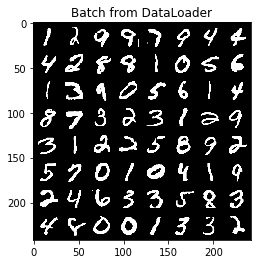

In [6]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from torchvision import utils
%matplotlib inline

def show_image(image): 
    pyplot.imshow(image, cmap="gray")

def show_mnist_batch(sample_batched):
    """Show images for a batch of samples."""
    images_batch = sample_batched[0]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from DataLoader')
    
# Displays the first batch of images
for i, batch in enumerate(train_loader):
    if i==1:
        break
    show_mnist_batch(batch)

### Part 2  - Models, Loss Functions and Optimizers (10 points)

In this section, we will do the following:
* Learn about how to build your deep learning model and define its parameters
* Choose a loss function to optimize
* Choose an optimization method to maximize/minimize the loss

We'll first start with a single layer neural network to do handwritten digit classification. The math may ring some bells from homework 7.

`torch.nn` is the module we will be using here. You can find the API at https://pytorch.org/docs/stable/nn.html. There is also a quick summary at https://pytorch.org/tutorials/beginner/nn_tutorial.html#closing_thoughts.

#### Models

We will use the following python modules in building our one layer model.

* `torch.nn.Module`: Your model will be abstracted as a python class. Your python class must subclass `torch.nn.Module`. It is the base class for all neural network modules in PyTorch (Do not confuse python modules with PyTorch Modules). These implement the `forward()` function which defines how your model handles input and produces an output. Your model class can also have `torch.nn.Module`s as members, allowing nested tree like structures, and it is leveraging this that you are able to build neural networks in PyTorch.   

* `torch.nn.Linear`: A unit of computation in neural networks are *Layers* and PyTorch provides abstractions for layers as `nn.Modules`. These come in many forms including *Convolutional*, *Recurrent*, and *Linear*. You can find the API for linear layers here https://pytorch.org/docs/stable/nn.html#linear-layers.

**Now use the information provided to define the `OneLayerModel` class below. The superclass constructor has been called for you, and this allows your subclass to access superclass methods and members.**
* **Finish the `__init__()` function.**
* **Finish the `forward()` function.** (Hint: Use that fact that layer modules implement their own `forward()` function)





In [7]:
from torch import nn
import math

class OneLayerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lin = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.lin(x)

#### Loss Functions and Optimizers

You've defined your model but now what? It's just a black box that takes an input and spits out some numbers. You haven't yet defined what it means to be a good or bad model. 

A ***Loss Function*** takes what your model outputs and compares it to what it *should* have put out. It returns some  meaningful value used to update your model parameters, and so train your model. Check out Section 21.2.1 of the textbook for more details about types of loss functions. The Loss function represents the overall goal of building this model, and the choice of loss function is very important. 

We must examine our model parameters and our problem instance to see about how to choose a loss function.
* We take in a 784-dimensional vector and output 10 real values, giving our model 784 x 10 parameters. 
* It is natural given that our problem is an instance of *multi-class classification* that we would want each of our output values to model `P(y==i|x)`.
* If we go this route, we get an added constraint that the sum of all 10 of our output values should be 1 (forming a probability mass distribution).

Turns out there is a very convenient loss function for just our use case known as ***cross-entropy loss***. Check out this reference https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy for a little more intuition on this.

Once again, PyTorch has abstractions built in for us in the `torch.nn` module, namely `torch.nn.CrossEntropyLoss`. The API can be found at https://pytorch.org/docs/stable/nn.html#crossentropyloss. 

We're still not ready to train our model because while we have some parameters, and we have some measure of how good or bad our predictions are, we have no notion of how to go about updating our parameters in order to improve our loss. 

This is where ***Optimizers*** come in. In general, we have one main way of minimizing loss functions (training our models), and that is through *Stochastic Gradient Descent* https://en.wikipedia.org/wiki/Stochastic_gradient_descent. There are many variants and optimizations of this method, however, and the `torch.optim` package gives us abstractions for these. The API can be found at https://pytorch.org/docs/stable/optim.html#.

In [8]:
from torch import optim

### Part 3 - Training and Validation (45 points)

In this section we will learn how to use the concepts we've learned about so far to train the model we built, and validate how well it does.We also want to monitor how well our training is going while it is happening. 

For this we can use a package called `tensorboardX`. You will need to install this package using `pip` or `Anaconda`, based on your dev environment. Additionally, we'll want to use a logging module called `tensorboardX.SummaryWriter`. You can consult the API here https://tensorboardx.readthedocs.io/en/latest/tutorial.html. Run the next cell to ensure that all is working well.

In [9]:
""" Try uncommenting these commands if you're facing issues here
!pip3 install -U protobuf
!pip3 install -U tensorflow
!pip3 install -U tensorboardX
"""
%load_ext tensorboard.notebook
from tensorboardX import SummaryWriter

We have provided the code to use `tensorboard` just before calling your `train` function. You don't have to change the top-level log directory, but you can create multiple runs (different parameters or versions of your code) just by creating subdirectories for these within your top-level directory.

**Now use the information provided above to do the following:**
* ** Instantiate a `OneLayerModel` with the appropriate input/output parameters.**
* ** Define a cross-entropy loss function.**
* ** Define a stochastic gradient descent optimizer based for you model's parameters. Start with a learning rate of 0.001, and adjust as necessary. You can start with the vanilla `optim.SGD` optimizer, and change it if you wish.** 
* **Create a `SummaryWriter` object that will be responsible for logging our training progress into a directory called `logs/expt1` (Or whatever you wish your top-level directory to be called).**

In [10]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
learning_rate = .0001
model = OneLayerModel(784,10)
loss = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
writer = SummaryWriter()

We've finally come to the point where we need to write our training set up. We're going to use both our training and testing (validation) sets for this. Note that traditionally, you would separate part of your training data into validation data in order to get an unbiased estimate of how your model performs, but here we'll just pretend that our testing data is our validation data. 

**Training a model with batches of data broadly involves the following steps:**
1. **One `epoch` is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2. **In each epoch, set your model to train mode.** 
3. **you feed your model `batch_size` examples at a time, and receive `batch_size` number of outputs until you've gotten through your entire dataset.**
4. **Calculate the loss function for those outputs given the labels for that batch.**
5. **Now calculate the gradients for each model parameter.** (Hint: Your loss function object can do this for you)
6. **Update your model parameters** (Hint: The optimizer comes in here)
7. **Set the gradients in your model to zero for the next batch.**
8. **After each epoch, set your model to evaluation mode.**
9. **Now evaluate your model on the validation data. Log the total loss and accuracy over the validation data.** (Note: PyTorch does automatic gradient calculations in the background through its `Autograd` mechanism https://pytorch.org/docs/stable/notes/autograd.html. Make sure to do evaluation in a context where this is turned off!)

**Complete the `train()` function below. Try to make it as general as possible, so that it can be used for improved versions of you model. Feel free to define as many helper functions as needed.**
**Make sure that you do the following: **
* **Log the *training loss* and *training accuracy* on each batch for every epoch, such that it will show up on `tensorboard`.**
* **Log the loss on the validation set and the accuracy on the validation set every epoch**

**You will need to produce the plots for these.**

You may also want to add some print statements in your training function to report progress in this notebook.

In [23]:
def accuracy(predictions, y):
    preds = torch.argmax(predictions, dim=1)
    return (preds == y).float().mean()

def train(model, train_loader, val_loader, loss_func, opt,num_epochs=10, writer=None):
    model.train()
    for epoch in range(num_epochs):
        for x, y in train_loader:
            pred = model(x)
            loss = loss_func(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            valid_loss = torch.Tensor([loss_func(model(x), y) for x, y in val_loader])
            valid_loss = torch.mean(valid_loss)
            valid_accuracy = torch.Tensor([accuracy(model(x), y) for x, y in val_loader])
            valid_accuracy = torch.mean(valid_accuracy)
            print(valid_loss, valid_accuracy)

Finally call `train` with the relevant parameters. Run the tensorboard command on your top-level logs directory to monitor training. If there is logging data from a previous run, just delete the directory for the run, and reinstantiate the `SummaryWriter` for that run. (You may want to reinstantiate the model itself if you want to clear the model parameters too).

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand. 

In [25]:
#%tensorboard --logdir=logs
train(model, train_loader, test_loader, loss, optimizer, 12, writer)

tensor(0.3506) tensor(0.9046)
tensor(0.3428) tensor(0.9062)
tensor(0.3365) tensor(0.9066)
tensor(0.3310) tensor(0.9078)
tensor(0.3264) tensor(0.9094)


__Final Validation Loss:__ *Put Value Here*

__Final Validation Accuracy:__ *Put Value Here*

#### What is familiar about a 1-layer neural network with cross-entopy loss? Have you seen this before?

Answer: 

### Part 4 - Two Layer Neural Net (20 points)

The thing that makes neural networks really powerful is that they are able to do complex function approximation. As we saw earlier, we can organize the computation done in neural networks into units called *layers*. In a general neural network, there is an *input layer*, and an *output layer*. These may be the same layer as they were in our previous example. When they are not the same, there are intermediate layers known as _hidden layers_. These layers receive input from other layers and send their output to other layers. 

We have been dealing with a certain type of neural network known as a __fully connected__ network. For our purposes, this just means that the output of the layer is just the dot product of its input `x`, its weights `w` plus a bias term `b`, all wrapped in a non-linear *activation function* `F`.  

`y = F(w^T x + b)`.

These non-linear activation functions are very important but where in our last neural network did we apply such a function? Implicitly we applied what's known as a __softmax activation__ in order to compute cross-entropy loss https://en.wikipedia.org/wiki/Softmax_function.

We'll now try to create a neural network with one hidden layer. This means that we have to come up with an activation function for the output of that hidden layer. A famous, simple but powerful activation function is the __Rectified Linear Unit (ReLU)__ function defined nas `ReLU(x) = max(x,0)`. We will use this on the output of the hidden layer.

`torch.nn` has a module known as `nn.Sequential` that allows us to chain together other modules. This module implements a `forward()` function that automatically handles input-output connections etc. Check out the API at https://pytorch.org/docs/stable/nn.html#sequential. 

**Just like you did with the single layer model, define a class `TwoLayerModel`, a neural network with ReLU activation for the hidden layer. `nn.Sequential` may come in handy.**

In [ ]:
class TwoLayerModel(nn.Module):
    ## YOUR CODE HERE ##
    def __init__(self):
        pass

**Once again use the information provided above to do the following:**
* ** Instantiate a `TwoLayerModel` with the appropriate input/output/hidden layer parameters.**
* ** Define a cross-entropy loss function again.**
* ** Define a stochastic gradient descent optimizer based for you model's parameters. Start with a learning rate of 0.001, and adjust as necessary. You can start with the vanilla `optim.SGD` optimizer, and change it if you wish.** 
* **Create a `SummaryWriter` object that will be responsible for logging our training progress into a directory called `logs/expt2` (Or whatever you wish your top-level directory to be called, just make sure the subdirectory is different from your previous SummaryWriter).**

In [ ]:
## YOUR CODE HERE ##
model2 = None
loss2 = None
optimizer2 = None
writer2 = None

Call `train` on your two layer neural network.

In [ ]:
#%tensorboard --logdir=logs
train(model2, train_loader, test_loader, loss2, optimizer2, 15, writer2)

__Final Validation Loss:__ *Put Value Here*

__Final Validation Accuracy:__ *Put Value Here*

#### Did your accuracy on the validation set improve with multiple layers? Why do you think this is ?

Answer: 

### Part 5 - What is being learned at each layer? (10 points)

So what exactly are these weights that our network is learning at each layer? By conveniently picking our layer dimensions as perfect square numbers, we can try to visualize the weights learned at each layer as square images. Use the following function to do so for *all interesting layers* across your models. Feel free to modify the function as you wish. 

**At the very least, you must generate:**
1. **The ten 28x28 weight images learned by your one layer model.**
2. **The 256 28x28 weight images learned by the hidden layer in your two-layer model.**

In [ ]:
def visualize_layer_weights(model, layer_idx, num_images, image_dim, title):
    # Find number of rows and columns based on number of images
    for d in range(1,num_images):
        f = num_images/d
        if int(f)==f:
            dim1 = int(min(f,d))
            dim2 = int(max(f,d))
        if d > f:
            break    
    # Plot weights as square images
    fig, ax  = plt.subplots(dim1, dim2)
    
    # At least 1 inch by 1 inch images
    fig.set_size_inches(dim2, dim1)
    weights = (list(model.parameters())[layer_idx])
    fig.suptitle(title)
    for i in range(dim1):
        for j in range(dim2):
            ax[i][j].imshow(weights[dim2*i+j].reshape(image_dim,image_dim).detach().numpy(), cmap='gray')